In [202]:
import os
import random
from datetime import datetime 

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from classifier import LinearClassifier

In [2]:
%reload_ext autoreload
%autoreload 2

# Обработка датасета

In [3]:
data = pd.read_csv("heart.csv")
data["output"] = data["output"].replace({0: -1})
data.head(5)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [5]:
sc = MinMaxScaler()
columns = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']
data[columns] = sc.fit_transform(data[columns])

Y = data["output"].to_numpy().reshape(-1, 1)
X = data.drop(["output"], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 13), (242, 1), (61, 13), (61, 1))

In [6]:
np.unique(y_test, return_counts=True)

(array([-1,  1], dtype=int64), array([25, 36], dtype=int64))

# Обучение

In [17]:
def calculate_margin(w, X, y):
    return (X @ w.T) * y

def plot_margin(margins):
    margins = np.sort(margins.flatten())
    plt.plot(margins, c='k', linewidth=3)

    plt.axhline(y=0, c='k', linewidth=0.5)

    x = np.arange(len(margins))
    plt.gca().fill_between(x, margins, where=(margins>=0.3), color='#00ff00')
    plt.gca().fill_between(x, margins, where=(margins<=-0.3), color='#ff0000')
    plt.gca().fill_between(x, margins, where=np.bitwise_and(margins >= -0.3, margins <= 0.3), color='#ffff00')

    plt.ylabel("Margin")
    plt.gcf().set_size_inches(5, 3)


def plot_classifier_logs(classifier):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].plot(classifier.loss_history, c='b')
    axes[0].set_title("Loss")
    N = 32
    # smooth_loss = np.convolve(classifier.loss_history, np.ones(N)/N, mode='valid')
    cumsum = np.cumsum(np.insert(classifier.loss_history, 0, 0)) 
    smooth_loss = (cumsum[N:] - cumsum[:-N]) / float(N)
    axes[0].plot(smooth_loss, 'r--')


    axes[1].plot(classifier.Q_history, c='r')
    axes[1].set_title("Quality Functional")


## Обучение с различными параметрами

### Классический классификатор с регуляризацией

In [ ]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights()
classifier.fit(X_train, y_train,
               n_iter=10000,
               lr=1e-2, 
               lambda_=0.001,
               reg=0.5,
               momentum=False,
               gamma=0.9,
               optimize_lr=False,
               use_margins=False)

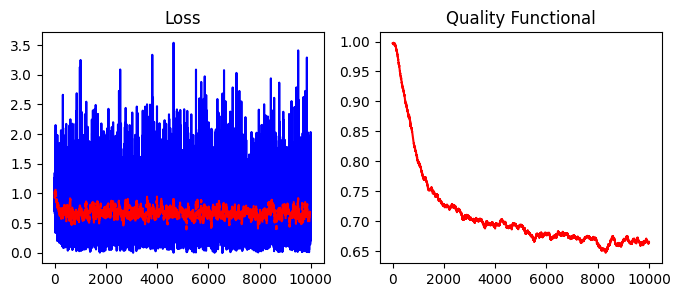

In [123]:
plot_classifier_logs(classifier)

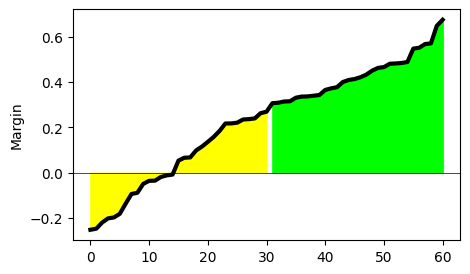

In [124]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [125]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.75      0.60      0.67        25
           1       0.76      0.86      0.81        36

    accuracy                           0.75        61
   macro avg       0.75      0.73      0.74        61
weighted avg       0.75      0.75      0.75        61



### Классический классификатор с регуляризацией и моментами Нестерова

In [ ]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights()
classifier.fit(X_train, y_train,
               n_iter=10000,
               lr=1e-2, 
               lambda_=0.001,
               reg=0.5,
               momentum=True,
               gamma=0.9,
               optimize_lr=False,
               use_margins=False)

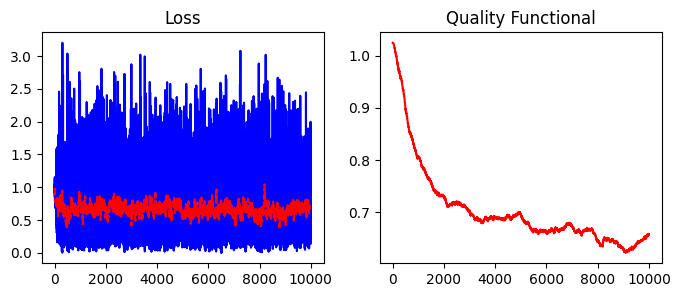

In [117]:
plot_classifier_logs(classifier)

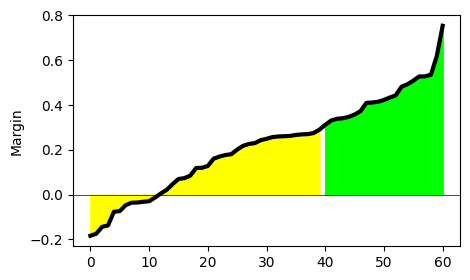

In [118]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [119]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.74      0.80      0.77        25
           1       0.85      0.81      0.83        36

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



### Классический классификатор с регуляризацией, моментами Нестерова и оптимальным lr

In [133]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights()
classifier.fit(X_train, y_train,
               n_iter=10000,
               lr=1e-3, 
               lambda_=0.001,
               reg=0.5,
               momentum=True,
               gamma=0.9,
               optimize_lr=True,
               use_margins=False)

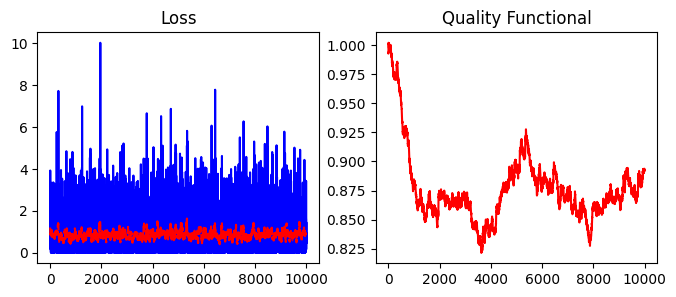

In [134]:
plot_classifier_logs(classifier)

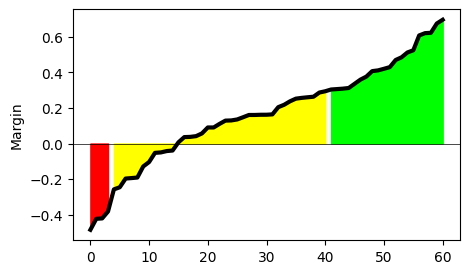

In [135]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [136]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.81      0.52      0.63        25
           1       0.73      0.92      0.81        36

    accuracy                           0.75        61
   macro avg       0.77      0.72      0.72        61
weighted avg       0.77      0.75      0.74        61



## Обучение с различными параметрами

Далее будет использоваться **классический классификатор с регуляризацией и моментами Нестерова** как наиболее стабильный и качественный из всех представленных выше

### Инициализация весов через корреляцию

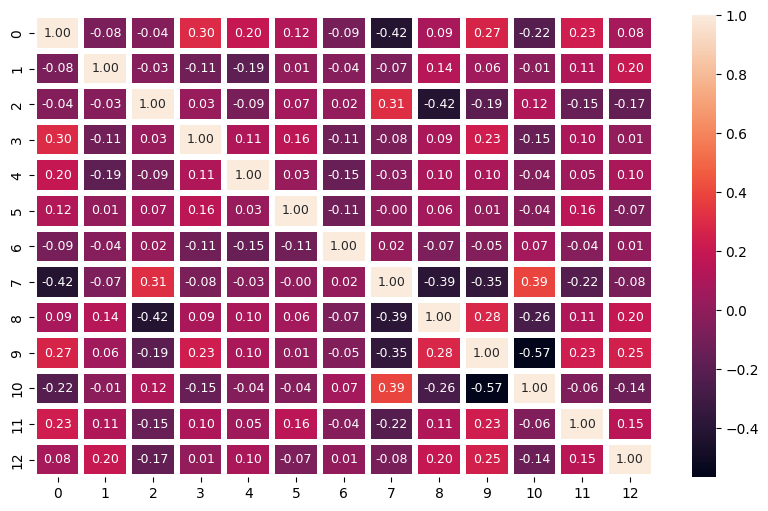

In [ ]:
import seaborn as sns

corr_matrix = np.corrcoef(X_train.T)
sns.heatmap(corr_matrix, annot=True, linewidths=3, fmt=".2f", annot_kws={'size': 9}, xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(10, 6)

Корреляция между признаками незначительна, поэтому приближение будет близко к оптимальному

In [169]:
w = np.array([
    (y_train.T @ X_train[:, i]) / (X_train[:, i].T @ X_train[:, i]) 
    for i in range(X.shape[1])
]).T
w, w.shape


(array([[-0.039, -0.076,  0.767,  0.011,  0.035, -0.056,  0.336,  0.319,
         -0.542, -1.038,  0.275, -0.823, -0.017]]),
 (1, 13))

In [198]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights(w=w)
classifier.fit(X_train, y_train,
               n_iter=10000,
               lr=1e-3, 
               lambda_=0.01,
               reg=0.5,
               momentum=True,
               gamma=0.9,
               optimize_lr=False,
               use_margins=False)

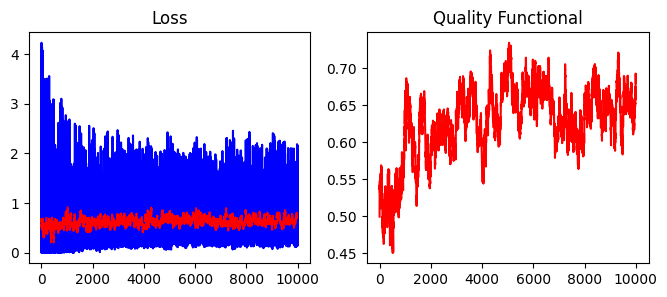

In [199]:
plot_classifier_logs(classifier)

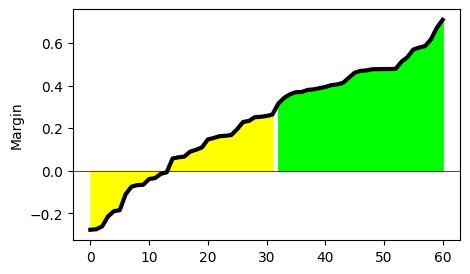

In [200]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [201]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.79      0.60      0.68        25
           1       0.76      0.89      0.82        36

    accuracy                           0.77        61
   macro avg       0.78      0.74      0.75        61
weighted avg       0.77      0.77      0.76        61



### Обучение с мультистартом

In [ ]:
multi_N = 15

best_acc = -1
best_idx = None
best_weights = None


for i in range(multi_N):

    classifier = LinearClassifier(X_train.shape[1])
    classifier.init_weights()
    classifier.fit(X_train, y_train,
                n_iter=10000,
                lr=1e-2, 
                lambda_=0.01,
                reg=0.5,
                momentum=True,
                gamma=0.9,
                optimize_lr=False,
                use_margins=False)
    y_res = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_res)
    if acc >= best_acc:
        best_acc = acc
        best_idx = i
        best_weights = classifier.w
    print(f"idx={i} has accuracy={acc:.3f}")

print(f"best idx={best_idx} has accuracy={best_acc:.3f}")
print(f"best weights: {best_weights}")


idx=0 has accuracy=0.689
idx=1 has accuracy=0.754
idx=2 has accuracy=0.803
idx=3 has accuracy=0.787
idx=4 has accuracy=0.754
idx=5 has accuracy=0.803
idx=6 has accuracy=0.787
idx=7 has accuracy=0.787
idx=8 has accuracy=0.770
idx=9 has accuracy=0.820
idx=10 has accuracy=0.803
idx=11 has accuracy=0.754
idx=12 has accuracy=0.803
idx=13 has accuracy=0.705
idx=14 has accuracy=0.770
best idx=9 has accuracy=0.820
best weights: [[-0.145 -0.217  0.241 -0.066 -0.027 -0.087  0.086  0.189 -0.347 -0.179
   0.208 -0.249 -0.123]]


In [205]:
classifier = LinearClassifier(X_train.shape[1])
classifier.init_weights(w=best_weights)

y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.69      1.00      0.82        25
           1       1.00      0.69      0.82        36

    accuracy                           0.82        61
   macro avg       0.85      0.85      0.82        61
weighted avg       0.87      0.82      0.82        61



### Обучение с рандомным семплированием и вероятностным

In [219]:
n_features = X.shape[1]
starting_weight = np.random.uniform(low=-1/(2*n_features), high=1/(2*n_features), size=(1, n_features))

In [228]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights(w=starting_weight)

classifier.fit(X_train, y_train,
               n_iter=20000,
               lr=1e-3, 
               lambda_=0.001,
               reg=0.5,
               momentum=True,
               gamma=0.9,
               optimize_lr=False,
               use_margins=True)

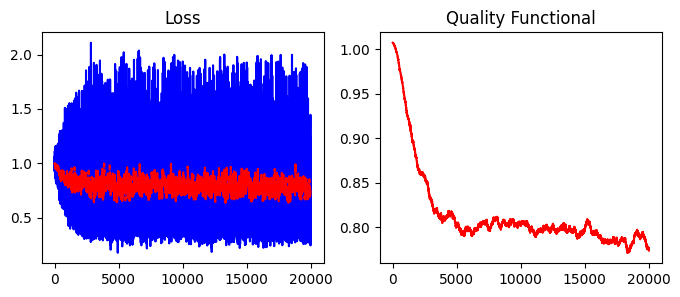

In [229]:
plot_classifier_logs(classifier)

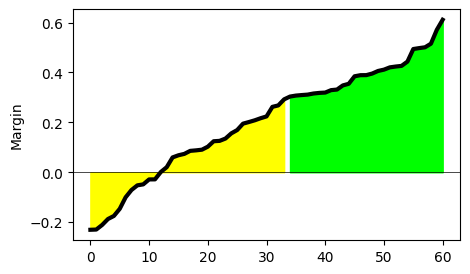

In [231]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [232]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.88      0.60      0.71        25
           1       0.77      0.94      0.85        36

    accuracy                           0.80        61
   macro avg       0.83      0.77      0.78        61
weighted avg       0.82      0.80      0.79        61



In [233]:
classifier = LinearClassifier(X.shape[1])
classifier.init_weights(w=starting_weight)

classifier.fit(X_train, y_train,
               n_iter=20000,
               lr=1e-3, 
               lambda_=0.001,
               reg=0.5,
               momentum=True,
               gamma=0.9,
               optimize_lr=False,
               use_margins=False)

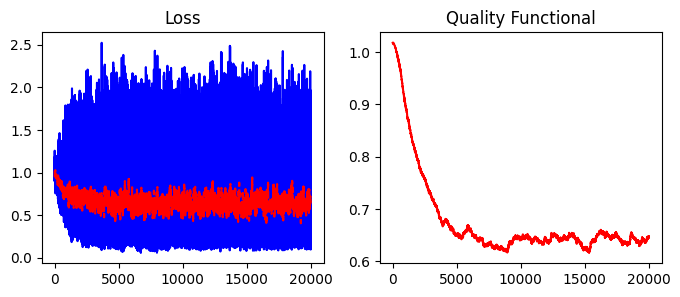

In [234]:
plot_classifier_logs(classifier)

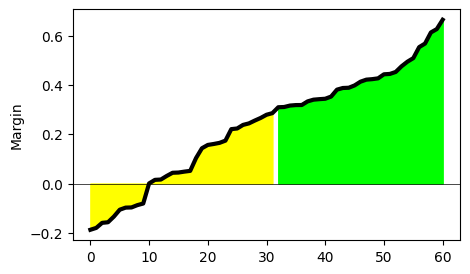

In [235]:
margins = calculate_margin(classifier.w, X_test, y_test)
plot_margin(margins)

In [236]:
y_res = classifier.predict(X_test)
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.83      0.76      0.79        25
           1       0.84      0.89      0.86        36

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



## Эталонное решение

In [237]:
from sklearn.linear_model import SGDClassifier

In [241]:
clsf = SGDClassifier()
clsf.fit(X_train, y_train)

D:\DOCS\МАГИСТРАТУРА 1 курс\Фунд. основы систем ИИ\fundamentals\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier()

In [242]:
y_res = clsf.predict(X_test)

In [243]:
print(classification_report(y_test, y_res))

              precision    recall  f1-score   support

          -1       0.84      0.64      0.73        25
           1       0.79      0.92      0.85        36

    accuracy                           0.80        61
   macro avg       0.81      0.78      0.79        61
weighted avg       0.81      0.80      0.80        61

